In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import xarray as xr
from IPython.display import HTML

from tool.dataset import NetCDFDataset
from tool.loss import RMSELoss
from tool.utils import Util, ImgUtil

## Loading Data from the Different Resolutions

In [3]:
file_high_res = './data/eta_eulerian_resolution_20.0km.nc'
file_low_res = './data/eta_eulerian_resolution_100.0km.nc'

In [4]:
# loading outputs from shallow water model and transposing dimensions
xr_high_res = xr.open_mfdataset(file_high_res).transpose('time', 'y', 'x')
xr_low_res = xr.open_mfdataset(file_low_res).transpose('time', 'y', 'x')

In [5]:
xr_high_res = xr_high_res.rename({'__xarray_dataarray_variable__':'eta'})
xr_low_res = xr_low_res.rename({'__xarray_dataarray_variable__':'eta'})

In [6]:
# filtering only time steps present in coarse resolution
xr_high_res_subset = xr_high_res.isel(time=slice(0, xr_high_res.time.size - 1, 5))

In [7]:
# reindexing the coarse resolution to match the same x and y dimension size from high resolution model
# from 20x20 to 100x100
# nan values are filled using two different methods 'ffill' and 'nearest'
xr_low_res_100_f = xr_low_res.reindex(x=xr_high_res_subset.x, y=xr_high_res_subset.y, method='ffill')
xr_low_res_100_n = xr_low_res.reindex(x=xr_high_res_subset.x, y=xr_high_res_subset.y, method='nearest')

In [8]:
# try the same as above, but using interpolation
xr_low_res_100_interp = xr_low_res.interp_like(xr_high_res_subset, method='linear')

In [9]:
# organizing data to plot a gif
data = [xr_low_res_100_f.eta.values, 
        xr_low_res_100_n.eta.values, 
        xr_low_res_100_interp.eta.values,
        xr_high_res_subset.eta.values]
titles = ['Low Res FFill', 'Low Res Nearest', 'Low Res Intepolation', 'High Res']

In [10]:
# getting minimum from datasets
min1, min2 = xr_low_res_100_f.eta.min().values, xr_low_res_100_n.eta.min().values
min3, min4 = xr_low_res_100_interp.eta.min().values, xr_high_res_subset.eta.min().values
_min = np.min(np.array([min1, min2, min3, min4]))

In [11]:
# getting maximun from datasets
max1, max2 = xr_low_res_100_f.eta.max().values, xr_low_res_100_n.eta.max().values
max3, max4 = xr_low_res_100_interp.eta.max().values, xr_high_res_subset.eta.max().values
_max = np.max(np.array([max1, max2, max3, max4]))

In [12]:
%%capture
# creating gif animation
%matplotlib notebook
g = ImgUtil(data, titles, _min, _max)
# frames indicates how many steps should be printed
anim = g.get_animation_gif(frames=100, cmap='viridis')

In [13]:
HTML(anim.to_jshtml())

## Comparing Low vs High Resolution

In [14]:
def get_loss(target, output):
    rmse_loss, mae_loss, x = [], [], []
    criterium = torch.nn.MSELoss()

    for i in range(target.shape[0]):
        yhat, y = output[i,:,:], target[i,:,:]
        yhat, y = torch.from_numpy(yhat), torch.from_numpy(y)
        rmse_loss.append(torch.sqrt(criterium(yhat, y)))
        mae_loss.append(F.l1_loss(yhat, y))
        
    return rmse_loss, mae_loss

In [28]:
rmse_loss, mae_loss = get_loss(xr_high_res_subset.eta.values, xr_low_res_100_f.eta.values)

<IPython.core.display.Javascript object>


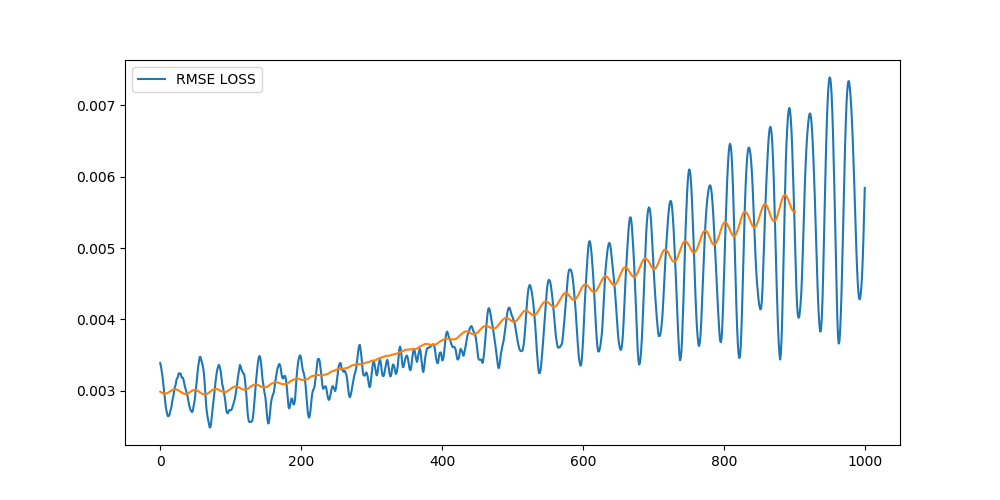

In [29]:
rm = np.convolve(rmse_loss[:1000], np.ones(100), 'valid') / 100
plt.figure(figsize=(10,5))
plt.plot(rmse_loss[:1000], label="RMSE LOSS")
plt.plot(rm)
plt.legend(loc="upper left")

<IPython.core.display.Javascript object>


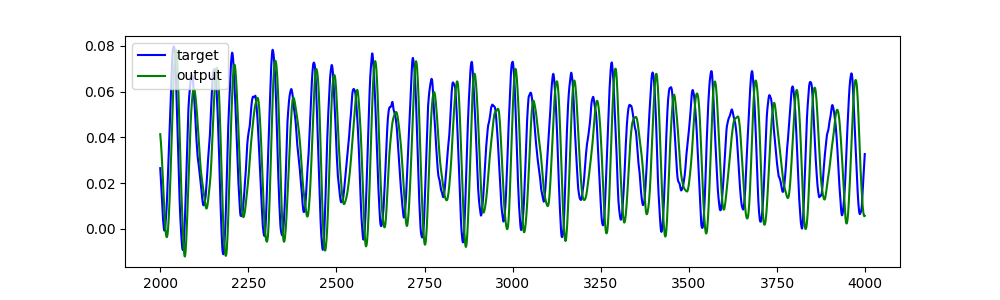

In [17]:
length = 2000
shift = 2000
f = shift + length

plt.figure(figsize=(10,3))
plt.plot(np.arange(shift, f), xr_high_res_subset.eta.values[shift:f,50,50], "-b", label="target")
plt.plot(np.arange(shift, f), xr_low_res_100_n.eta.values[shift:f,50,50], "-g", label="output")
plt.legend(loc="upper left")

plt.show()

## Loading Trained DL Model

Two models were trained.

Both use the last five 'states' to predict the next five 'states'.

The difference between then is that while in model_5 the 'states' are five steps away from each other (+- 6 min), in model_25 they are 25 steps away (=- 30 min).

In [ ]:
def load_checkpoint(filename, model_name, dataset_type=None, model=None, optimizer=None):
    if not(os.path.isabs(filename)):
        filename = os.path.join('/home/jguinelli/mestrado/stconvs2s/output', dataset_type, 'checkpoints', model_name.lower(), filename)  
    epoch, loss = 0.0, 0.0
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        name = os.path.basename(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f'=> Loaded checkpoint {name} (best epoch: {epoch}, validation rmse: {loss:.4f})')
    else:
        print(f'=> No checkpoint found at {filename}')

    return model

In [ ]:
from model.stconvs2s import STConvS2S_R

In [ ]:
# same parameters from training
x_shape = [1, 1, 5, 100, 100]
num_layers = 3
hidden_dim = 32
kernel_size = 5
device = torch.device('cuda')
dropout_rate = 0
step = 5

In [ ]:
opt_params = {
    'lr': 0.001,
    'alpha': 0.9,
    'eps': 1e-6
}

In [ ]:
model_5 = STConvS2S_R(x_shape, num_layers, hidden_dim, kernel_size, device, dropout_rate, step)
model_5.to(device)
optimizer_5 = torch.optim.RMSprop(model_5.parameters(), **opt_params)

In [ ]:
model_25 = STConvS2S_R(x_shape, num_layers, hidden_dim, kernel_size, device, dropout_rate, step)
model_25.to(device)
optimizer_25 = torch.optim.RMSprop(model_25.parameters(), **opt_params)

In [ ]:
# files with checkpoints from each training epoch
filename_5 = 'dataset-shallow-water-eta-20.0km_step5_4_20210103-051048.pth.tar'
filename_25 = 'dataset-shallow-water-eta-20.0km_step5_4_20210101-183602.pth.tar'
dataset_type = 'full-dataset'
model_name = 'stconvs2s-r'

In [ ]:
# loading weigths from best epoch
model_5 = load_checkpoint(filename_5, model_name, dataset_type, model_5, optimizer_5)
model_25 = load_checkpoint(filename_25, model_name, dataset_type, model_25, optimizer_25)

## Getting Data for Simulation

In [ ]:
# getting last 20% of the dataset for test
start_i = int(np.ceil(xr_high_res_subset.eta.shape[0] * 0.8))
eta_test = xr_high_res_subset.eta.values[start_i:]

In [ ]:
# generating input and expected output (target)
input_5, target_5 = eta_test[:5], eta_test[5:750+5]
input_25, target_25 = eta_test[:25:5], eta_test[25:750+25:5]

In [ ]:
# 6min * 750 (aprox. 3 days)
input_5.shape, target_5.shape

In [ ]:
# 30min * 150 (aprox. 3 days)
input_25.shape, target_25.shape

In [ ]:
pt_input_5 = torch.tensor(input_5[None, None], dtype=torch.float)
pt_target_5 = torch.tensor(target_5[None, None], dtype=torch.float)
pt_input_25 = torch.tensor(input_25[None, None], dtype=torch.float)
pt_target_25 =  torch.tensor(target_25[None, None], dtype=torch.float)

### Predicting (Not Finished)

In [ ]:
def make_predictions(model, initial_input, steps, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        i_input = initial_input
        i_input = i_input.to(device)
        for i in range(steps):
            output = model(i_input)
            predictions.append(output)
            i_input = output
    
    return predictions

In [ ]:
predictions_5 = make_predictions(model=model_5, initial_input=pt_input_5, steps=150, device=device)
predictions_25 = make_predictions(model=model_25, initial_input=pt_input_25, steps=30, device=device)

In [ ]:
# concatenating predictions
pt_output_5 = torch.cat(predictions_5, dim=2)
pt_output_25 = torch.cat(predictions_25, dim=2)

In [ ]:
output_5 = pt_output_5.cpu().numpy()
output_25 = pt_output_25.cpu().numpy()

In [ ]:
pt_output_5.shape

In [ ]:
pt_output_25.shape

## Analysing Predictions

In [ ]:
# organizing data to plot a gif
diff = output_5[0,0] - target_5
data = [target_5, 
        output_5[0,0], 
        diff]
titles = ['Target', 'Output', 'Diff']

In [ ]:
target_5.shape

In [ ]:
%%capture
# creating gif animation
%matplotlib notebook
g = ImgUtil(data, titles, _min, _max)
# frames indicates how many steps should be printed
anim = g.get_animation_gif(frames=100, cmap='viridis')

In [ ]:
HTML(anim.to_jshtml())

## In Construction

In [ ]:
forecast_folder = "./results/"

In [ ]:
# loading predictions made on test dataset by 2 different trained models
# the number at the end indicates the distance between each prediction (steps)
target_5 = torch.load(forecast_folder + 'dataset-shallow-water-eta-20.0km_step5_4_20210103-051048-targets.pt')
output_5 = torch.load(forecast_folder + 'dataset-shallow-water-eta-20.0km_step5_4_20210103-051048-outputs.pt')

target_25 = torch.load(forecast_folder + 'dataset-shallow-water-eta-20.0km_step5_4_20210101-183602-targets.pt')
output_25 = torch.load(forecast_folder + 'dataset-shallow-water-eta-20.0km_step5_4_20210101-183602-outputs.pt')

In [ ]:
# getting numpy representation from tensors
np_target_5 = target_5.cpu().numpy()
np_output_5 = output_5.cpu().numpy()

np_target_25 = target_25.cpu().numpy()
np_output_25 = output_25.cpu().numpy()

In [ ]:
diff = (np_target_5[0,0,:,:,:] - np_output_5[0,0,:,:,:])*10
data = [np_target_5[0,0,:,:,:], np_output_5[0,0,:,:,:], diff]
titles = ["Target", "Output", "Diff"]
frames = 5

In [ ]:
%matplotlib notebook
plt.ioff()
#g = ImgUtil(data, titles, _min, _max)
g = ImgUtil(data, titles, 0.0163, 0.056)
anim = g.get_animation_gif(frames, 'viridis')
HTML(anim.to_jshtml())

In [ ]:
def get_loss(target, output):
    rmse_loss, mae_loss, x = [], [], []
    criterium = torch.nn.MSELoss()
    #criterium = RMSELoss()

    print('RMSE: {}'.format(criterium(output, target)))
    print('MAE : {}'.format(F.l1_loss(output, target)))

    for i in range(target.size()[2]):
        yhat, y = output[:,:,i,:,:], target[:,:,i,:,:]
        rmse_loss.append(torch.sqrt(criterium(yhat, y)))
        #rmse_loss.append(criterium(yhat, y))
        mae_loss.append(F.l1_loss(yhat, y))
        x.append(i+1)
        
    return rmse_loss, mae_loss, x

In [ ]:
%matplotlib inline
rmse_loss, mae_loss, x = get_loss(target_5, output_5)
width = 0.4
fig_bar = plt.figure(figsize=(10,3))
ax = fig_bar.add_axes([0,0,1,1])
ax.bar(np.arange(1,len(x)+1)-width/2, rmse_loss, width=0.4, color='b', label='RMSE')
ax.bar(np.arange(1,len(x)+1)+width/2, mae_loss, width=0.4, color='y', label='MAE')
ax.set_xticks(x)
plt.ylabel('error')
plt.xlabel('prediction')
plt.legend(loc="upper center")

In [ ]:
length = 5000

plt.figure(figsize=(10,3))
plt.plot(np.arange(1,length+1), np_target_5[:length,0,4,30,30], "-b", label="target")
plt.plot(np.arange(1,length+1), np_output_5[:length,0,4,30,30], "-g", label="output")
plt.legend(loc="upper left")
#plt.ylim(0.036, 0.154)
plt.show()

In [ ]:
length = 5000

plt.figure(figsize=(10,3))
plt.plot(np.arange(1,length+1), np_target_5[:length,0,4,50,50], "-b", label="target")
plt.plot(np.arange(1,length+1), np_output_5[:length,0,4,50,50], "-g", label="output")
plt.legend(loc="upper left")
#plt.ylim(0.01, 0.06)
plt.show()

### TO DO

In [ ]:
dataset_file = '/home/jguinelli/mestrado/stconvs2s/data/dataset-shallow-water-eta-20.0km-yseq5-ystep25.nc'

ds = xr.open_mfdataset(dataset_file)

test_split = 0.2
validation_split = 0.2
test_dataset = NetCDFDataset(ds, test_split=test_split, 
                             validation_split=validation_split, is_test=True)

In [ ]:
def __init_seed(number=0):
    seed = (number * 10) + 1000
    np.random.seed(seed)

In [ ]:
params = {'batch_size': 8, 
          'num_workers': 4, 
          'worker_init_fn': __init_seed}
test_loader = DataLoader(dataset=test_dataset, shuffle=False, **params)